In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
import getpass
import statsmodels.api as sm

sns.set_style("white")

In [2]:
conn = pymysql.connect(host="localhost",
                       port=3306,
                       user="root",
                       passwd=getpass.getpass(),
                       db="olist")

········


OLIST rand a Black Friday campaign on Nov. 24th 2017

The analytics team is tasked to evaluated its success!

## Get weekly revenue data
| week_id | revenue |
|---------|---------|
| 2017-01-01| 234098|
|2017-01-08 | 3948209| 

timeframe: from beginning of 2017 until september 2018
- only want full weeks 

DATE_SUB (how you can subtract dates)

DAYOFWEEK

In [21]:
revenue_query = """
SELECT 
    DATE_SUB(DATE(o.order_purchase_timestamp), 
            INTERVAL DAYOFWEEK(DATE(o.order_purchase_timestamp)) - 1 DAY) AS week_id,
    SUM(oi.price)                                                         AS revenue
FROM orders o
    JOIN order_items oi
    ON o.order_id = oi.order_id
WHERE DATE(o.order_purchase_timestamp) > '2017-01-02'
    AND DATE(o.order_purchase_timestamp) < '2018-09-03'
    AND o.order_status = 'delivered'
GROUP BY week_id
ORDER BY week_id
"""

In [22]:
revenue = pd.read_sql(revenue_query, conn)

In [11]:
revenue.head()

,week_id,revenue
0,2017-01-01,2665.180000
1,2017-01-08,9165.069994
2,2017-01-15,21951.900026
3,2017-01-22,50239.989901
4,2017-01-29,66531.949844


In [12]:
revenue.dtypes

week_id     object
revenue    float64
dtype: object

In [14]:
revenue["week_id"] = pd.to_datetime(revenue["week_id"])

## Approach 1:
Compare the week of Black Friday to time period before

In [23]:
week = revenue.copy()

In [26]:
week = week.loc[week["week_id"].between(pd.to_datetime("2017-11-12"), pd.to_datetime("2017-11-19"))]

In [27]:
week

,week_id,revenue
45,2017-11-12,174613.250068
46,2017-11-19,371858.770386


In [35]:
week.loc[week["week_id"] == pd.to_datetime("2017-11-12"), "revenue"].values[0]
#test without values, doesn't work
#week.loc[week["week_id"] == pd.to_datetime("2017-11-12"), "revenue"][0]

174613.2500681877

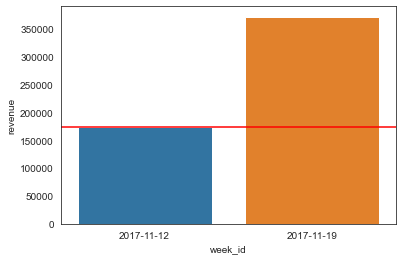

In [37]:
ax = sns.barplot(data=week, 
            x="week_id",
            y="revenue");
ax.axhline(week.loc[week["week_id"] == pd.to_datetime("2017-11-12"), "revenue"].values[0], color="r");

Calculate the difference

In [40]:
prev_week = week.loc[week["week_id"] == pd.to_datetime("2017-11-12"), "revenue"].values[0]
bf_week = week.loc[week["week_id"] == pd.to_datetime("2017-11-19"), "revenue"].values[0]

In [42]:
abs_diff = bf_week - prev_week
rel_diff = (bf_week / prev_week) - 1

In [45]:
#(bf_week / prev_week) - 1

1.1296137048076567

In [43]:
print(f"""The revenue for the week including Black Friday increased by {round(rel_diff*100, 2)}% compared to the
week prior. Assuming the Black Friday promotion accounts for the entire difference, we were able to increase our 
revnue by {round(abs_diff, 2)}""")

The revenue for the week including Black Friday increased by 112.96% compared to the
week prior. Assuming the Black Friday promotion accounts for the entire difference, we were able to increase our 
revnue by 197245.52


Look at time series

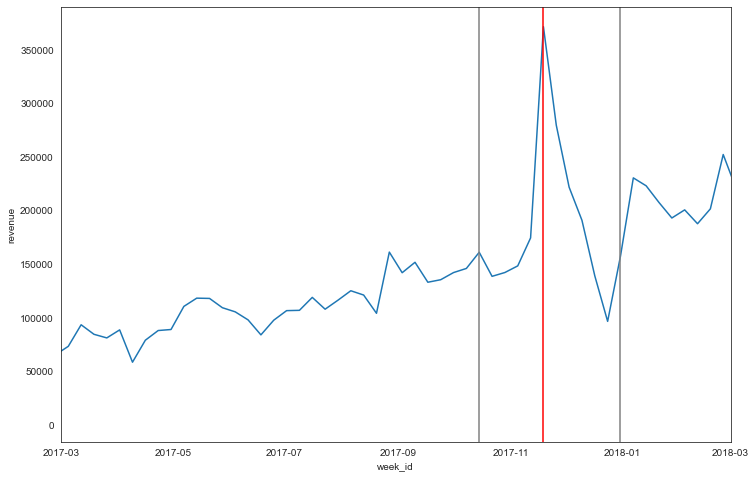

In [51]:
fig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(data=revenue, 
             x="week_id", 
             y="revenue", 
             ax=ax);

#removing data we don't need
ax.set_xlim((pd.to_datetime("2017-03-01")), pd.to_datetime("2018-03-01"));
ax.axvline(pd.to_datetime("2017-11-19"), color="r");

ax.axvline(pd.to_datetime("2017-10-15"), color="grey");
ax.axvline(pd.to_datetime("2017-12-31"), color="grey");

The graph suggests that revenue decreased in some time periods immediatly before and after the week of Black Friday, which indicated consumers may have changed their purchasing behavior. That is, some consumers may have postponed or preponed a purchase to save money. We can also see that revnue has probalby increase throughout the year of 2017.

We can 'bake in' these additional assumptions through considering a time range instead of just the week affected (change in behavior) and through estimating a trend line (trend). 

## Approach 2:
Establish baseline considering overall trend and change in behavior